c:\Users\Robin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[0.3922, 0.3922, 0.3922,  ..., 0.4706, 0.4706, 0.4706],
        [0.3922, 0.3922, 0.3922,  ..., 0.4706, 0.4706, 0.4706],
        [0.3922, 0.3922, 0.3922,  ..., 0.4706, 0.4706, 0.4706],
        ...,
        [0.6824, 0.6275, 0.6196,  ..., 0.1490, 0.1255, 0.1216],
        [0.6627, 0.6353, 0.7569,  ..., 0.1686, 0.1608, 0.1216],
        [0.7608, 0.6745, 0.7490,  ..., 0.1686, 0.1686, 0.1686]])


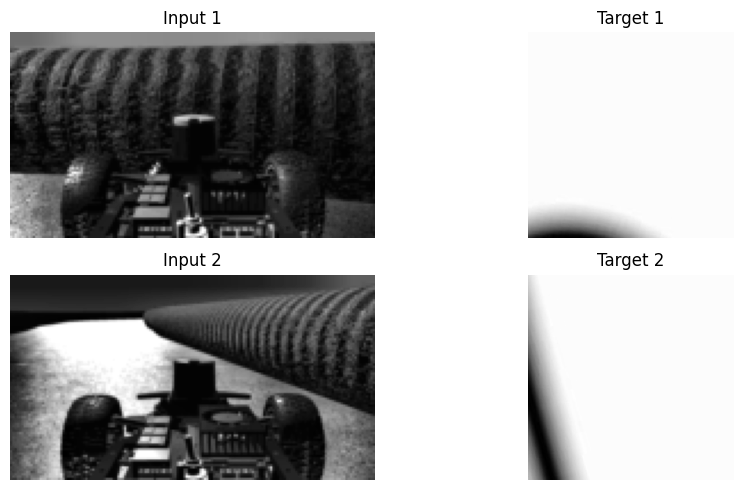

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Dataset personnalisé
class ImageToImageDataset(Dataset):
    def __init__(self, input_folder, target_folder, transform_input=None, transform_target=None):
        self.input_folder = input_folder
        self.target_folder = target_folder
        self.input_files = sorted(os.listdir(input_folder))  # Trier pour matcher les paires
        self.target_files = sorted(os.listdir(target_folder))  # Trier pour matcher les paires
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Charger l'image d'entrée
        input_path = os.path.join(self.input_folder, self.input_files[idx])
        input_image = cv2.imread(input_path)  # Charger avec OpenCV
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Convertir en RGB

        # Charger l'image cible
        target_path = os.path.join(self.target_folder, self.target_files[idx])
        target_image = cv2.imread(target_path)  # Charger avec OpenCV
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)  # Convertir en RGB

        # Appliquer les transformations
        if self.transform_input:
            input_image = self.transform_input(input_image)
        if self.transform_target:
            target_image = self.transform_target(target_image)

        return input_image, target_image


# Dossiers d'entrée et de sortie
input_folder = "C:/Users/Robin/Documents/POSTECH/Deep Learning theory/Projet/dashcam"  # Remplace par le chemin de tes inputs
target_folder = "C:/Users/Robin/Documents/POSTECH/Deep Learning theory/Projet/costmap"  # Remplace par le chemin des cibles

# Transformations pour l'entrée et la cible
transform = transforms.Compose([
    transforms.ToPILImage(),                  # Convertir depuis OpenCV à PIL
    transforms.Grayscale(num_output_channels=1),  # Convertir en niveaux de gris
    transforms.Resize((720 // 8, 1280 // 8)), # Downsample
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.], std=[1.]),                # Convertir en tenseur
])
transform_target = transforms.Compose([
    transforms.ToPILImage(),                  # Convertir depuis OpenCV à PIL
    transforms.Grayscale(num_output_channels=1),  # Convertir en niveaux de gris
    transforms.ToTensor(),                   # Convertir en tenseur
])
# Créer le dataset
dataset = ImageToImageDataset(
    input_folder=input_folder,
    target_folder=target_folder,
    transform_input=transform,
    transform_target=transform_target
)

# DataLoader
batch_size = 100
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# exemple : afficher deux paires d'images (input et target)
batch_inputs, batch_targets = next(iter(data_loader))

plt.figure(figsize=(10, 5))
print(batch_inputs[0].squeeze())

# afficher la première paire
plt.subplot(2, 2, 1)
plt.imshow(batch_inputs[0].squeeze(), cmap='gray')  # input 1
plt.title("input 1")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(batch_targets[0].squeeze(), cmap='gray')  # target 1
plt.title("target 1")
plt.axis('off')

# afficher la deuxième paire
plt.subplot(2, 2, 3)
plt.imshow(batch_inputs[1].squeeze(), cmap='gray')  # input 2
plt.title("input 2")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(batch_targets[1].squeeze(), cmap='gray')  # target 2
plt.title("target 2")
plt.axis('off')

plt.tight_layout()
plt.show()


In [2]:
import torch.nn as nn

class CostMapCNN(nn.Module):
    def __init__(self):
        super(CostMapCNN, self).__init__()
        self.layers = nn.Sequential(
            # Première couche : 48 filtres, kernel 7x7, stride 1, padding 3
            nn.Conv2d(1, 48, kernel_size=7, dilation=1, padding=3, stride=1),
            nn.ReLU(),

            # Deuxième couche : 64 filtres, kernel 3x3, stride 1, padding 1
            nn.Conv2d(48, 64, kernel_size=3, dilation=1, padding=1, stride=1),
            nn.ReLU(),

            # Troisième couche : 128 filtres, kernel 3x3, stride 1, padding 1
            nn.Conv2d(64, 128, kernel_size=3, dilation=1, padding=1, stride=1),
            nn.ReLU(),

            # Quatrième couche : 32 filtres, kernel 3x3, stride 1, padding 2 (dilation 2)
            nn.Conv2d(128, 32, kernel_size=3, dilation=2, padding=2, stride=1),
            nn.ReLU(),

            # Cinquième couche : 32 filtres, kernel 3x3, stride 1, padding 4 (dilation 4)
            nn.Conv2d(32, 32, kernel_size=3, dilation=4, padding=4, stride=1),
            nn.ReLU(),

            # Sixième couche : 32 filtres, kernel 3x3, stride 1, padding 8 (dilation 8)
            nn.Conv2d(32, 32, kernel_size=3, dilation=8, padding=8, stride=1),
            nn.ReLU(),

            # Septième couche : 32 filtres, kernel 3x3, stride 1, padding 16 (dilation 16)
            nn.Conv2d(32, 32, kernel_size=3, dilation=16, padding=16, stride=1),
            nn.ReLU(),

            # Huitième couche : 32 filtres, kernel 3x3, stride 1, padding 32 (dilation 32)
            nn.Conv2d(32, 32, kernel_size=3, dilation=32, padding=32, stride=1),
            nn.ReLU(),

            # Dernière couche : 1 filtre, kernel 3x3, stride 1, padding 1
            nn.Conv2d(32, 1, kernel_size=3, dilation=1, padding=1, stride=1),

            # Redimensionnement final pour obtenir exactement 150x150
            nn.Upsample(size=(150, 150), mode='bilinear', align_corners=True)
        )
    
    def forward(self, x):
        return self.layers(x)

In [17]:
import torch.optim as optim
from tqdm import tqdm
# Initialiser le modèle
model = CostMapCNN()

# Définir la loss (L1 Loss) et l'optimiseur
criterion = nn.L1Loss()  # L1 Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimiseur Adam avec un taux d'apprentissage de 0.001

# Entraînement
num_epochs = 1
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_inputs, batch_targets in tqdm(data_loader):
        # Mettre à jour les gradients à 0
        optimizer.zero_grad()
        
        # Passer les données dans le modèle
        outputs = model(batch_inputs)
        
        # Calculer la perte
        loss = criterion(outputs, batch_targets)
        
        # Backpropagation
        loss.backward()
        
        # Optimisation
        optimizer.step()
        
        # Accumuler la perte
        running_loss += loss.item()
        print(loss)
    
    # Afficher la perte moyenne par époque
    print(f"Époque [{epoch + 1}/{num_epochs}], Perte moyenne : {running_loss / len(data_loader):.4f}")

print("Entraînement terminé !")


  1%|▏         | 1/67 [00:16<18:34, 16.89s/it]

tensor(0.9083, grad_fn=<L1LossBackward>)


  3%|▎         | 2/67 [00:34<18:55, 17.46s/it]

tensor(0.8916, grad_fn=<L1LossBackward>)


  4%|▍         | 3/67 [00:52<18:58, 17.79s/it]

tensor(0.8680, grad_fn=<L1LossBackward>)


  6%|▌         | 4/67 [01:13<19:48, 18.87s/it]

tensor(0.8453, grad_fn=<L1LossBackward>)


  7%|▋         | 5/67 [01:34<20:17, 19.63s/it]

tensor(0.7930, grad_fn=<L1LossBackward>)


  9%|▉         | 6/67 [01:56<20:38, 20.30s/it]

tensor(0.6600, grad_fn=<L1LossBackward>)


 10%|█         | 7/67 [02:17<20:50, 20.84s/it]

tensor(0.4008, grad_fn=<L1LossBackward>)


 12%|█▏        | 8/67 [02:41<21:10, 21.53s/it]

tensor(0.7239, grad_fn=<L1LossBackward>)


 13%|█▎        | 9/67 [03:04<21:26, 22.18s/it]

tensor(0.4153, grad_fn=<L1LossBackward>)


 15%|█▍        | 10/67 [03:28<21:37, 22.77s/it]

tensor(0.3896, grad_fn=<L1LossBackward>)


 16%|█▋        | 11/67 [03:54<22:03, 23.63s/it]

tensor(0.4705, grad_fn=<L1LossBackward>)


 18%|█▊        | 12/67 [04:27<24:21, 26.57s/it]

tensor(0.4990, grad_fn=<L1LossBackward>)


 19%|█▉        | 13/67 [04:57<24:47, 27.55s/it]

tensor(0.4962, grad_fn=<L1LossBackward>)


 21%|██        | 14/67 [05:22<23:41, 26.82s/it]

tensor(0.4562, grad_fn=<L1LossBackward>)


 22%|██▏       | 15/67 [05:46<22:24, 25.86s/it]

tensor(0.3731, grad_fn=<L1LossBackward>)


 24%|██▍       | 16/67 [06:10<21:29, 25.29s/it]

tensor(0.3380, grad_fn=<L1LossBackward>)


 25%|██▌       | 17/67 [06:33<20:39, 24.80s/it]

tensor(0.3746, grad_fn=<L1LossBackward>)


 27%|██▋       | 18/67 [06:57<19:57, 24.45s/it]

tensor(0.4271, grad_fn=<L1LossBackward>)


 28%|██▊       | 19/67 [07:20<19:15, 24.08s/it]

tensor(0.3412, grad_fn=<L1LossBackward>)


 30%|██▉       | 20/67 [07:44<18:51, 24.08s/it]

tensor(0.3088, grad_fn=<L1LossBackward>)


 31%|███▏      | 21/67 [08:08<18:21, 23.95s/it]

tensor(0.3281, grad_fn=<L1LossBackward>)


 33%|███▎      | 22/67 [08:31<17:53, 23.85s/it]

tensor(0.3490, grad_fn=<L1LossBackward>)


 34%|███▍      | 23/67 [08:56<17:34, 23.96s/it]

tensor(0.3470, grad_fn=<L1LossBackward>)


 36%|███▌      | 24/67 [09:19<17:04, 23.83s/it]

tensor(0.3238, grad_fn=<L1LossBackward>)


 37%|███▋      | 25/67 [09:42<16:33, 23.65s/it]

tensor(0.2941, grad_fn=<L1LossBackward>)


 39%|███▉      | 26/67 [10:06<16:02, 23.49s/it]

tensor(0.2885, grad_fn=<L1LossBackward>)


 40%|████      | 27/67 [10:29<15:35, 23.39s/it]

tensor(0.3000, grad_fn=<L1LossBackward>)


 42%|████▏     | 28/67 [10:52<15:12, 23.39s/it]

tensor(0.3039, grad_fn=<L1LossBackward>)


 43%|████▎     | 29/67 [11:16<14:58, 23.66s/it]

tensor(0.2577, grad_fn=<L1LossBackward>)


 45%|████▍     | 30/67 [11:40<14:39, 23.77s/it]

tensor(0.2690, grad_fn=<L1LossBackward>)


 46%|████▋     | 31/67 [12:04<14:15, 23.77s/it]

tensor(0.2811, grad_fn=<L1LossBackward>)


 48%|████▊     | 32/67 [12:28<13:54, 23.85s/it]

tensor(0.2522, grad_fn=<L1LossBackward>)


 49%|████▉     | 33/67 [12:52<13:30, 23.83s/it]

tensor(0.2379, grad_fn=<L1LossBackward>)


 51%|█████     | 34/67 [13:16<13:05, 23.81s/it]

tensor(0.2438, grad_fn=<L1LossBackward>)


 52%|█████▏    | 35/67 [13:39<12:38, 23.71s/it]

tensor(0.2238, grad_fn=<L1LossBackward>)


 54%|█████▎    | 36/67 [14:03<12:12, 23.64s/it]

tensor(0.2115, grad_fn=<L1LossBackward>)


 55%|█████▌    | 37/67 [14:27<11:52, 23.74s/it]

tensor(0.2145, grad_fn=<L1LossBackward>)


 57%|█████▋    | 38/67 [14:51<11:30, 23.80s/it]

tensor(0.2031, grad_fn=<L1LossBackward>)


 58%|█████▊    | 39/67 [15:15<11:08, 23.87s/it]

tensor(0.1984, grad_fn=<L1LossBackward>)


 60%|█████▉    | 40/67 [15:38<10:44, 23.85s/it]

tensor(0.1830, grad_fn=<L1LossBackward>)


 61%|██████    | 41/67 [16:02<10:16, 23.72s/it]

tensor(0.1827, grad_fn=<L1LossBackward>)


 63%|██████▎   | 42/67 [16:26<09:52, 23.70s/it]

tensor(0.1665, grad_fn=<L1LossBackward>)


 64%|██████▍   | 43/67 [16:49<09:24, 23.52s/it]

tensor(0.1833, grad_fn=<L1LossBackward>)


 66%|██████▌   | 44/67 [17:12<09:00, 23.48s/it]

tensor(0.1548, grad_fn=<L1LossBackward>)


 67%|██████▋   | 45/67 [17:36<08:38, 23.57s/it]

tensor(0.1729, grad_fn=<L1LossBackward>)


 69%|██████▊   | 46/67 [17:59<08:13, 23.49s/it]

tensor(0.1558, grad_fn=<L1LossBackward>)


 70%|███████   | 47/67 [18:22<07:48, 23.43s/it]

tensor(0.1741, grad_fn=<L1LossBackward>)


 72%|███████▏  | 48/67 [18:46<07:24, 23.41s/it]

tensor(0.1563, grad_fn=<L1LossBackward>)


 73%|███████▎  | 49/67 [19:09<07:00, 23.36s/it]

tensor(0.1571, grad_fn=<L1LossBackward>)


 75%|███████▍  | 50/67 [19:34<06:44, 23.80s/it]

tensor(0.1588, grad_fn=<L1LossBackward>)


 76%|███████▌  | 51/67 [19:57<06:17, 23.62s/it]

tensor(0.1439, grad_fn=<L1LossBackward>)


 78%|███████▊  | 52/67 [20:22<06:00, 24.00s/it]

tensor(0.1562, grad_fn=<L1LossBackward>)


 79%|███████▉  | 53/67 [20:48<05:42, 24.49s/it]

tensor(0.1541, grad_fn=<L1LossBackward>)


 81%|████████  | 54/67 [21:12<05:16, 24.34s/it]

tensor(0.1414, grad_fn=<L1LossBackward>)


 82%|████████▏ | 55/67 [21:35<04:49, 24.11s/it]

tensor(0.1408, grad_fn=<L1LossBackward>)


 84%|████████▎ | 56/67 [21:59<04:23, 23.95s/it]

tensor(0.1517, grad_fn=<L1LossBackward>)


 85%|████████▌ | 57/67 [22:22<03:58, 23.83s/it]

tensor(0.1360, grad_fn=<L1LossBackward>)


 87%|████████▋ | 58/67 [22:46<03:35, 23.89s/it]

tensor(0.1542, grad_fn=<L1LossBackward>)


 88%|████████▊ | 59/67 [23:11<03:12, 24.01s/it]

tensor(0.1494, grad_fn=<L1LossBackward>)


 90%|████████▉ | 60/67 [23:35<02:48, 24.04s/it]

tensor(0.1483, grad_fn=<L1LossBackward>)


 91%|█████████ | 61/67 [23:58<02:22, 23.80s/it]

tensor(0.1556, grad_fn=<L1LossBackward>)


 93%|█████████▎| 62/67 [24:22<01:58, 23.80s/it]

tensor(0.1337, grad_fn=<L1LossBackward>)


 94%|█████████▍| 63/67 [24:45<01:34, 23.67s/it]

tensor(0.1498, grad_fn=<L1LossBackward>)


 96%|█████████▌| 64/67 [25:09<01:11, 23.67s/it]

tensor(0.1393, grad_fn=<L1LossBackward>)


 97%|█████████▋| 65/67 [25:33<00:47, 23.71s/it]

tensor(0.1433, grad_fn=<L1LossBackward>)


 99%|█████████▊| 66/67 [25:56<00:23, 23.70s/it]

tensor(0.1527, grad_fn=<L1LossBackward>)


100%|██████████| 67/67 [26:11<00:00, 23.46s/it]

tensor(0.1494, grad_fn=<L1LossBackward>)
Époque [1/1], Perte moyenne : 0.3053
Entraînement terminé !


torch.Size([150, 150])
diff tensor(0.1186, grad_fn=<MeanBackward0>)


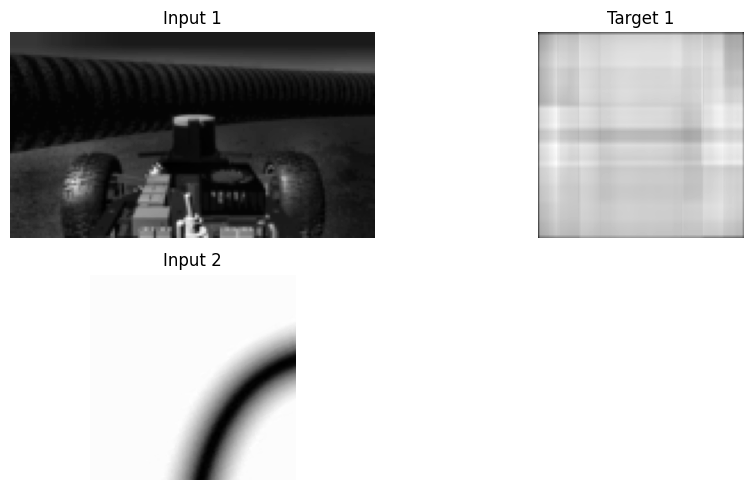

In [43]:
batch_size = 10
data_loader_2 = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Exemple : Afficher deux paires d'images (input et target)
batch_inputs_2, batch_targets_2 = next(iter(data_loader_2))

plt.figure(figsize=(10, 5))
res = model(batch_inputs_2)
print(res[0].squeeze().shape)
i = 6
im = res.detach().numpy()

diff = res[i].squeeze() - batch_targets_2[i].squeeze()
print("diff", torch.mean(diff))

# Afficher la première paire
plt.subplot(2, 2, 1)
plt.imshow(batch_inputs_2[i].squeeze(), cmap='gray')  # Input 1
plt.title("Input 1")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(im[i].squeeze(), cmap='gray')  # Target 1
plt.title("Target 1")
plt.axis('off')

# Afficher la deuxième paire
plt.subplot(2, 2, 3)
plt.imshow(batch_targets_2[i].squeeze(), cmap='gray')  # Input 2
plt.title("Input 2")
plt.axis('off')


plt.tight_layout()
plt.show()

In [13]:
print(model)
# Exemple avec une entrée fictive
dummy_input = torch.randn(1, 1, 90, 160)  # (batch_size, channels, height, width)
output = model(dummy_input)
print(f"Taille de sortie de la dernière couche : {output.shape}")


CostMapCNN(
  (layers): Sequential(
    (0): Conv2d(1, 48, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
    (11): ReLU()
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(16, 16), dilation=(16, 16))
    (13): ReLU()
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(32, 32), dilation=(32, 32))
    (15): ReLU()
    (16): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): Upsample(size=(150, 150), mode=bilinear)
  )
)
Tail